# Week 4 Submission

This project is to participate a Kaggle start competition titled "Natural Language Processing with Disaster Tweets." The objective of the competition is to develop a model to predict if a tweet indicates a real disaster or not. As the training dataset, 10,000 tweets manually labelled are provided. Since this is an assignment for a deep learning course, the models will be deep learning models.

In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

%matplotlib inline

## The data

The data is provided in csv format. I downloaded the files and loaded into Pandas dataframes.  The data structure and sample records look like following. The training dataset contains 7,613 records and the test dataset contains 3,263 records. Columns `keyword` and `location` have null values, but since we do not use those fields, we will simply ignore them. The `text` field does not cave any null value. The data contains extra new lines within the tweets, and the number of the lines of the files does not match the number of records, but Pandas’ `read_csv()` handles it properly.

## Data Cleansing

As the newline issue was handled by the pandas function, and the null values in keyword and location fields can be ignored, I did not have anything else to do with the data cleansing. 

The text field could be cleaned for the stop word elimination as well as removing URLs and tags, but I decided to keep those strings. I removed them all in the unsupervised learning project to see the effect of the content itself, but I would like to use all the information or words found in the tweet bodies in this project.

Finally, I split the training data into 75% and 25%, and used the 25% for the validation after the training.


In [146]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.info()
train_df.head()

In [ ]:
test_df.info()
test_df.head()

## Exploratory Data Analysis

The training data’s label count is shown below. I expected more positive records, but they are still well balanced. Then I plotted the number of characters and number of words in each tweet. The chart shows healthy distribution of the numbers. The correlation of those two factors is in line with the expectation. Interestingly, it looks more tweets labeled positive are found in longer tweets, and relatively smaller number of words for the length (bigger words?). I will see if this trend is significant.



0    4342
1    3271
Name: target, dtype: int64


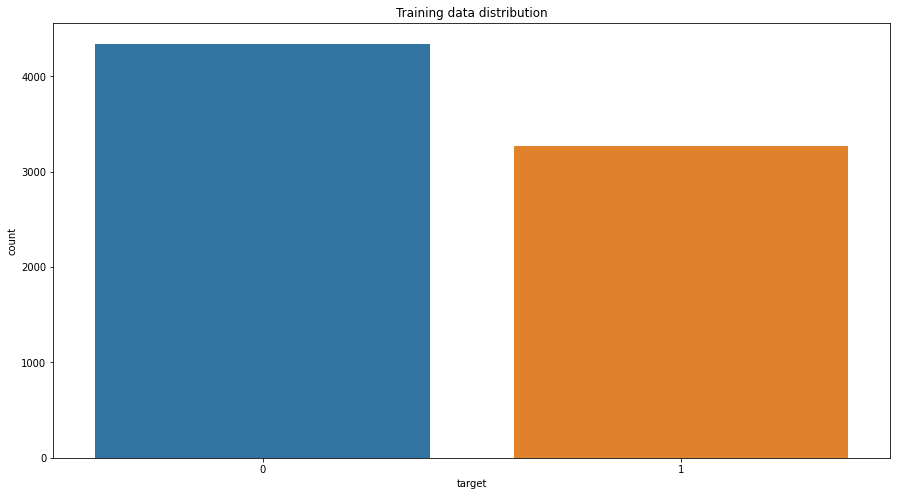

In [147]:
print (train_df['target'].value_counts())
plt.figure(figsize = (15,8))
plt.title("Training data distribution")
ax = sns.countplot(x = 'target', data=train_df)

In [148]:
train_df['length'] = train_df['text'].map(len)
train_df['num_words'] = train_df['text'].map(lambda x: len(x.split()))

<AxesSubplot:title={'center':'Training data distribution'}, xlabel='length', ylabel='num_words'>

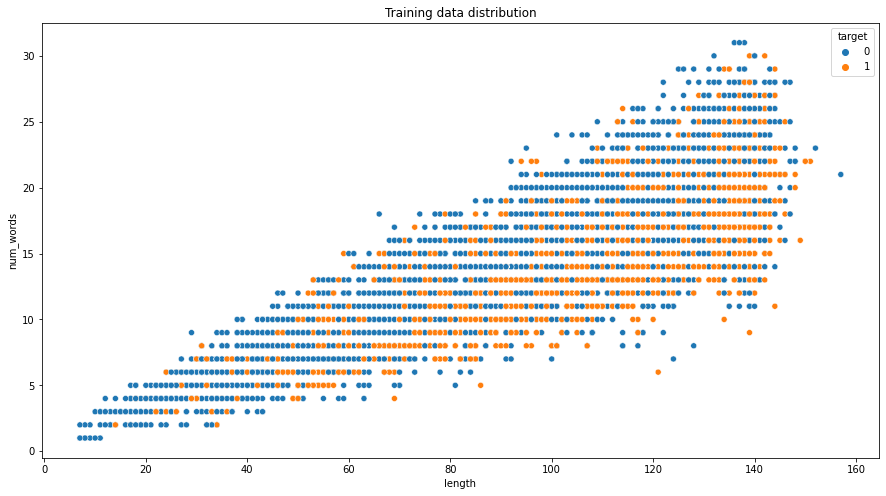

In [54]:
plt.figure(figsize = (15,8))
plt.title("Training data distribution")
sns.scatterplot(x='length', y='num_words', hue='target', data=train_df)

## Exploratory Data Analisys - verification with a quick model

To verify the intuitive observation, I built a simple support vector machine to see how the predictors, the length and number of the words, are actually predictive. The result below shows **63%** of accuracy rate, which is pretty high for a model that did not consider the meaning or semantics of the content at all. This is interesting, but I will not investigate further here. Assuming we are seeking for more predictive power, I will make sure that any model yields better performance than this.


In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(train_df[['length','num_words']],
                                                    train_df['target'], test_size=0.25, random_state=231) 
svc = SVC(probability=True, C=10, gamma=0.01)
svc.fit(X_train,y_train)

print ("-----------------Support Vector Machine on Length and Num Words-------------")
predictions = svc.predict(X_test)
print('Classification Report\n')
print(classification_report(y_test,predictions))
print('Confusion Matrix\n')
print(confusion_matrix(y_test,predictions))
print(f'\naccuracy score {accuracy_score(y_test,predictions)}')


-----------------Support Vector Machine on Length and Num Words-------------
Classification Report

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      1107
           1       0.56      0.59      0.57       797

    accuracy                           0.63      1904
   macro avg       0.63      0.63      0.63      1904
weighted avg       0.64      0.63      0.63      1904

Confusion Matrix

[[731 376]
 [324 473]]

accuracy score 0.6323529411764706


## Data Preparation and Simple Model

I tried a few vectorization including word-count vector and TFIDF, abut I could not get a proper predictiveness using the deep learning model while I got decent performance from random forest. 

I sifted through notebooks posted on Kaggle, and I found TensofFlow's Tokenizer offered the best outcome. I followed the steps described in https://www.kaggle.com/code/hassanelgafif/disaster-tweets-with-lstm/notebook.

First I built a Random Forest model for the baseline. It showed the following results. With about 70% of accuracy rate, it performed decently well, better than the SVC model above. The Random Forest yielded a better performance with text cleansing (such as deleting URLs), but I will consider this particular model as the reference performance of traditional supervised models. 



In [126]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

count_vectorizer = feature_extraction.text.CountVectorizer()
count_vectors = count_vectorizer.fit_transform(train_df["text"])
vocab_size =  len(count_vectorizer.get_feature_names_out())
embedding_dim = 64

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_df['text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=140)
y_train = train_df['target']


X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.25, random_state=231) 


-----------------random forest------------
Classification Report

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      1107
           1       0.67      0.54      0.60       797

    accuracy                           0.70      1904
   macro avg       0.69      0.67      0.68      1904
weighted avg       0.69      0.70      0.69      1904

Confusion Matrix

[[890 217]
 [363 434]]

accuracy score 0.6953781512605042


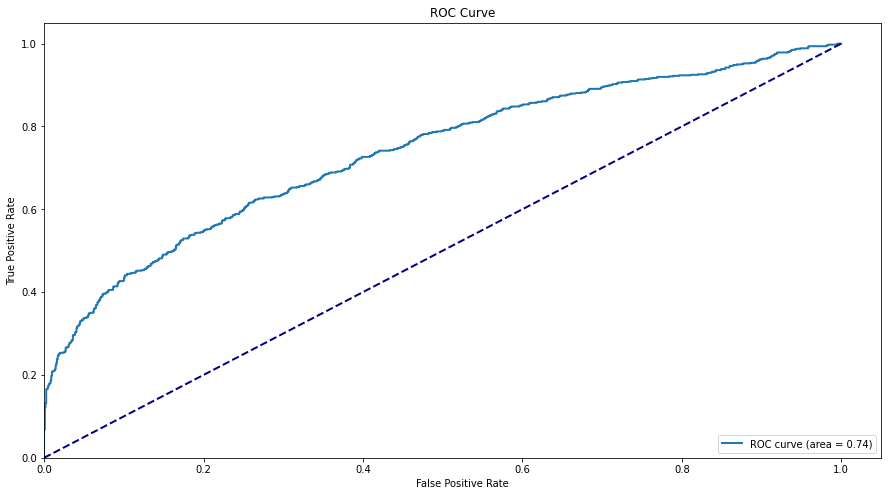

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rfc = RandomForestClassifier(n_estimators=6400, max_depth=32,min_samples_leaf=5 )
rfc.fit(X_train,y_train)

predictions = rfc.predict(X_test)

print (f"-----------------random forest------------")

print('Classification Report\n')
print(classification_report(y_test,predictions))
print('Confusion Matrix\n')
print(confusion_matrix(y_test,predictions))
print(f'\naccuracy score {accuracy_score(y_test,predictions)}')

predictions = rfc.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predictions)
roc_auc = roc_auc_score(y_test, predictions)

plt.figure(figsize = (15,8))
lw=2
plt.plot(
    fpr,
    tpr,
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


## Deep Learning Architectures
Since we are dealing with the tweets, which are sequence of words, and they do not have liner relationship with the response (if the tweet is genuinely about a disaster or not), recurrent neural network is the most appropriate model. To avoid very long training time and exploding or vanishing gradient, we should use more sophisticated algorithm than a vanilla recurrent neural network.


In fact, I tried SimpleRNN but the training was prohibitively slow and I gave up before evaluating the model's predictiveness. 


I tried two architectures - Long Short-Term Memory Cell and Gated Recurrent Unit. I also assessed the impact of the number of units by comparing various options. I simply trained models with various combinations and verified the outcomes. The comparison result was as shown below. 


The combinations are comparable and inconclusive. LSTM with 64 units marked the best performance but I assumed the stability would be preferable here and picked the GRU with 64 unites as the architecture for this project.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# List the architecture comparison - we will be focused on the middle layer here.
arch_list  = ['LSTM', 'GRU']
units_list = [8,16,32,64,96,128]
epochs = 20

# For the chart at the end
plot_points = {}

for arch in arch_list:
    plot_points[arch] = {'units':[], 'accuracy':[]}
    for units in units_list:
        model = keras.Sequential()
        model.add(layers.Embedding(vocab_size, embedding_dim, input_length=140))
        if arch_list=='LSTM':
            model.add(layers.Bidirectional(tf.keras.layers.LSTM(units)))
        elif arch_list=='GRU':
            model.add(layers.Bidirectional(tf.keras.layers.GRU(units)))    
        else:
            model.add(layers.Bidirectional(tf.keras.layers.SimpleRNN(units)))
                
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(1, activation = 'sigmoid'))

        # Build the model
        model.compile(
            loss='binary_crossentropy',
            optimizer='Adamax',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        
        # Train the model
        model.fit(X_train, y_train, epochs = epochs, batch_size = 256, validation_split=0.2, verbose = 0)
    
        # prediction using the hold out data
        prediction = model.predict(X_test, verbose=0).round()
        accuracy = accuracy_score(y_test,prediction)
        plot_points[arch]['units'].append(units)
        plot_points[arch]['accuracy'].append(accuracy)

plt.figure(figsize=(10,6))
for arch in arch_list:
    plt.plot(plot_points[arch]['units'],plot_points[arch]['accuracy'],marker='o', markersize=10, label=arch)
plt.title('Architecture comparison')
plt.xlabel('Units')
plt.ylabel('Accuracy')
plt.legend()


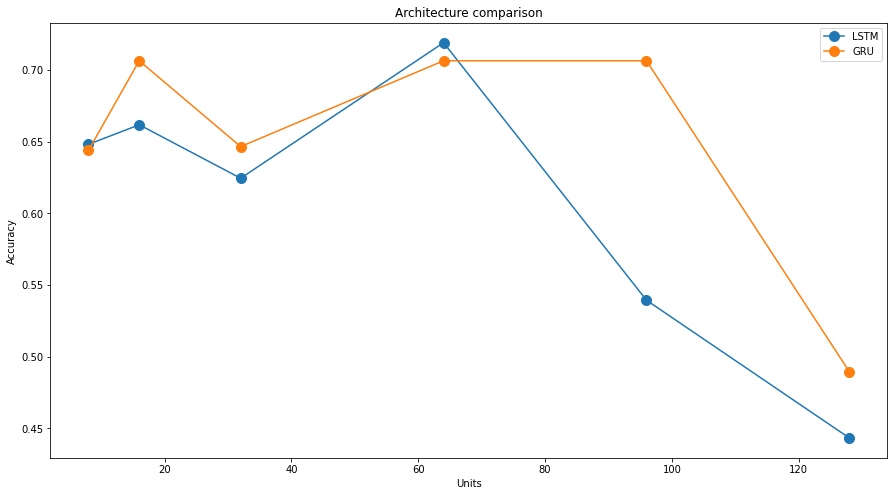

In [86]:
# Since the previous section takes a couple of hours to complete (and I deleted the real time output buffer), 
# I will re-populate the chart using the copied result data.

plot_points = {'LSTM': {'units': [8, 16, 32, 64, 96, 128],
  'accuracy': [0.648109243697479,
   0.6617647058823529,
   0.6244747899159664,
   0.7190126050420168,
   0.539390756302521,
   0.4432773109243697]},
 'GRU': {'units': [8, 16, 32, 64, 96, 128],
  'accuracy': [0.6439075630252101,
   0.7064075630252101,
   0.6465336134453782,
   0.7064075630252101,
   0.7064075630252101,
   0.4894957983193277]}}
plt.figure(figsize = (15,8))
for arch in ['LSTM','GRU']:
    plt.plot(plot_points[arch]['units'],plot_points[arch]['accuracy'],marker='o', markersize=10, label=arch)
plt.title('Architecture comparison')
plt.xlabel('Units')
plt.ylabel('Accuracy')
plt.legend()

## Hyperparameter tuning

Using the GRU with 64 unites model, I tried some hyperparameter tuning. I am showing the result of the combinations of epoch time and dropout values. Judging from the history, I would need more than 10 epoch times to train the model properly, but after 30, it appears to deteriorate with the holdout data. The dropout does not seem to give any boost to the final performance, but it will give the stability.

I also tried the variation of recurrernt_dropout but I did not find significant differences.

As a conclusion, I selected epochs=20 and dropout=0.8 as the hyperparameter values.


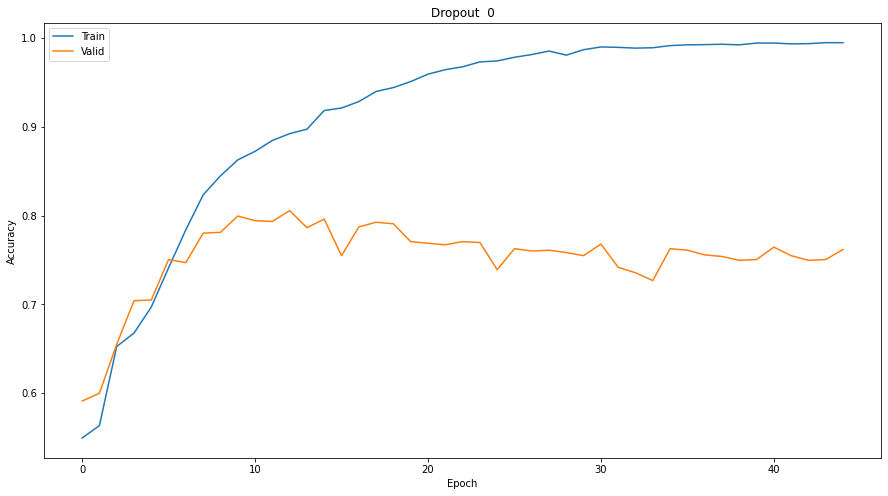

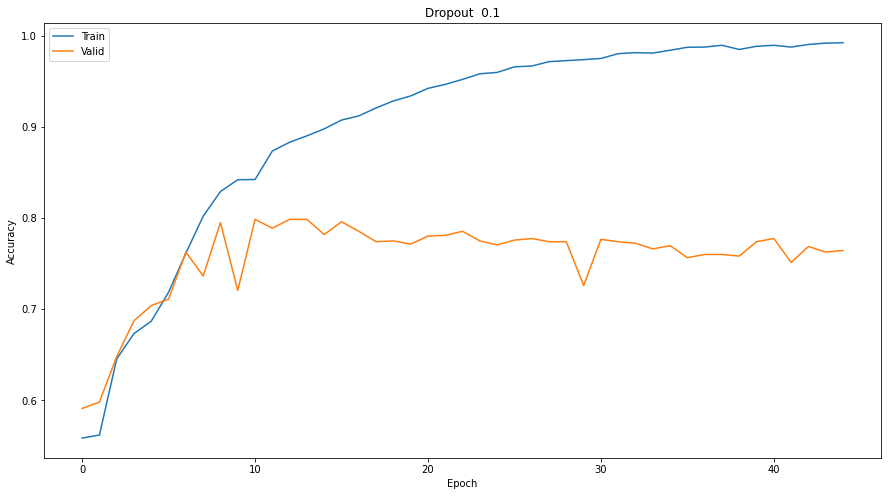

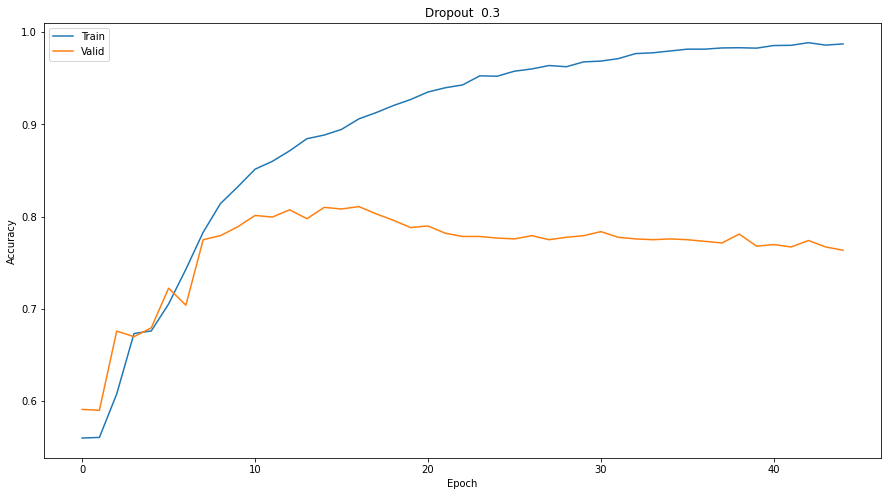

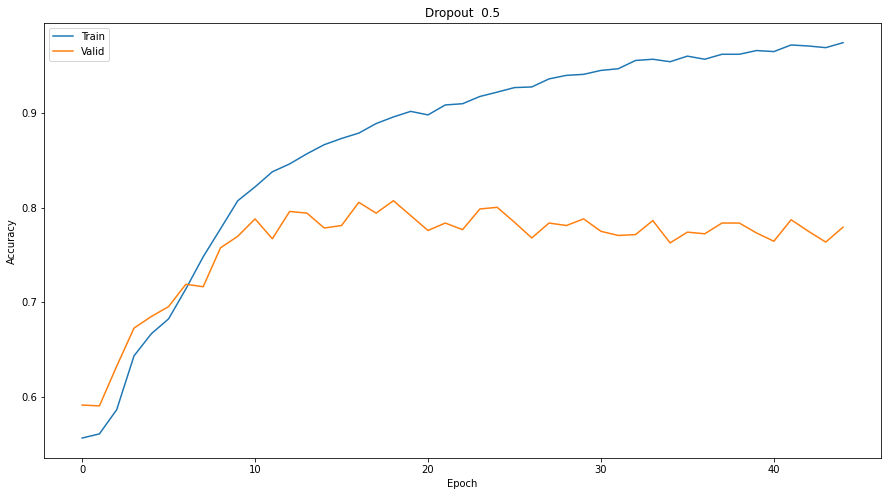

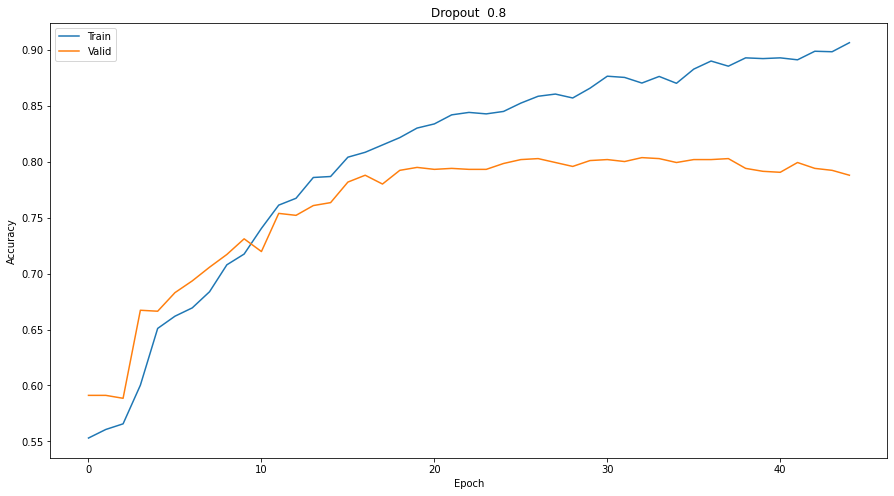

In [145]:

# Hyper parameter tuning - epoch time and dropout rate

for dropout in [0, 0.1, 0.3, 0.5, 0.8]:
    model = keras.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=140))
    model.add(layers.Bidirectional(tf.keras.layers.GRU(64, dropout=dropout)))    
#    model.add(layers.BatchNormalization())
# Removed normalization for it makes it difficult to see the trand along the epoch time.

    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Build the model
    model.compile(
        loss='binary_crossentropy',
        optimizer='Adamax',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Train the model
    history = model.fit(X_train, y_train, epochs = 45, batch_size = 256, validation_split=0.2, verbose = 0)

    plt.figure(figsize = (15,8))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Valid"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Dropout  "+str(dropout))
    plt.show()


## Result and Analysis
With those architecture and hyperparameters, I retrained the model and validated with the test data that I separated from the supplied training data, aside from the holdout data used for the training. 

The accuracy rate the confusion matrix are shown below. With the 80% accuracy rate, I got about 15% boost from random forest, and the confusion matrix looks decent. This proves the power and the suitability of recurrent neural network model for this particular problem.

The Kaggle submission shows the similar results (after fixing initial errors in the creation of the submission data).

As for the trouble shooting, I mostly struggled with the run time related hyperparameters. For example, when I set the batch size for the training too large, the interpreter crashed and I had to start all over again. Also the feature engineering of the input variables was challenging. As mentioned in Data Preparation, I did not succeed with some of the vectorization. This is also to be explored.


In [143]:
model = keras.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=140))
model.add(layers.Bidirectional(tf.keras.layers.GRU(64, dropout=0.8)))
model.add(layers.Dense(1, activation = 'sigmoid'))

    # Build the model
model.compile(
        loss='binary_crossentropy',
        optimizer='Adamax',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.fit(X_train, y_train, epochs = 30, batch_size = 256, validation_split=0.2, verbose = 0)

prediction = model.predict(X_test, verbose=0).round()
print (f"-----------------DL------------")

print('Classification Report\n')
print(classification_report(y_test,prediction))
print('Confusion Matrix\n')
print(confusion_matrix(y_test,prediction))
print(f'\naccuracy score {accuracy_score(y_test,prediction)}')



-----------------DL------------
Classification Report

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1107
           1       0.81      0.68      0.74       797

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904

Confusion Matrix

[[983 124]
 [255 542]]

accuracy score 0.8009453781512605


In [154]:
submission = pd.read_csv("sample_submission.csv")

X_submit = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=140)
submission["target"] = model.predict(pad_sequences(X_submit)).round().astype(int)
                                     
submission.to_csv("disaster_submission2.csv", index=False)

102/102 [==============================] - 3s 26ms/step


## Conslusion
Although the Kaggle ranking is not impressive, I am satisfied with the results that I got both with the local test data and from the Kaggle submission. I was able to see the power of the recurrent deep learning and how it was compared to traditional supervised models.

I was aware that deep learning is prone to overfitting. I tried to control it but I do not believe I was fully successful – I rather compromised with the model performance for it. There are still a lot to learn and experience. 


I could not get meaningful result the TFIDF based vectorization as mentioned above, partially because the computation was taking too long. There must be algorithmic improvement possible to accelerate the processing, which I would like to pursue going forward. The try-and-error process is essential in machine learning projects, and for deep learning project, computation time could be the limiting factor. This is another good lesson - use of proper algorithms to control running time is critical.